<h2>Importation des bibliothèques</h2>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

<h2>Lecture du fichier csv</h2>

In [ ]:
train = pd.read_csv('train.csv')

<h2>Création d'une copie du fichier csv</h2>

In [ ]:
train_copie = train.copy()

<i style="color:#90ADC6">-> je crée des copy des fichiers csv originaux car je ne veux pas écraser l'original.</p>

<h2>Affichage des données</h2>

In [ ]:
pd.set_option('display.max_columns', None)
train_copie.head()

In [ ]:
train_copie.describe()

In [399]:
train_copie[train_copie.duplicated()]

,CustomerId,TransactionStartTime,Value,Amount,TransactionId,BatchId,SubscriptionId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,TransactionStatus,IssuedDateLoan,AmountLoan,Currency,LoanId,PaidOnDate,IsFinalPayBack,InvestorId,DueDate,LoanApplicationId,PayBackId,ThirdPartyId,IsThirdPartyConfirmed,IsDefaulted,days_late
1971,CustomerId_50,2019-03-17 19:02:00,1000.0,-1000.0,TransactionId_703,BatchId_467,SubscriptionId_7,UGX,256,ProviderId_1,ProductId_7,airtime,ChannelId_1,0,NaT,NaN,NaN,NaN,NaT,0,NaN,NaT,NaN,NaN,NaN,0,0,NaN
1973,CustomerId_50,2019-03-17 19:02:00,1000.0,-1000.0,TransactionId_703,BatchId_467,SubscriptionId_7,UGX,256,ProviderId_1,ProductId_7,airtime,ChannelId_1,0,NaT,NaN,NaN,NaN,NaT,0,NaN,NaT,NaN,NaN,NaN,0,0,NaN
1975,CustomerId_50,2019-03-17 19:02:00,1000.0,-1000.0,TransactionId_703,BatchId_467,SubscriptionId_7,UGX,256,ProviderId_1,ProductId_7,airtime,ChannelId_1,0,NaT,NaN,NaN,NaN,NaT,0,NaN,NaT,NaN,NaN,NaN,0,0,NaN


<h2>Vérification des valeurs nulles</h2>

In [ ]:
train_copie.isnull().sum()

<i style="color:#90ADC6">->je vois qu'il y a des lignes en trop dans DueDate, LoanApplicationId, ThirdPartyId, et je trouve ça anormal, par exemple, pourquoi est-ce qu'il y a 614 dates limite du remboursement (DueDate) mais seulement 612 id de transaction de prêt (LoanId), il y a 2 lignes de trop ? </p>

In [ ]:
train_null = train_copie[train_copie.isna().any(axis=1)]
train_null

<i style="color:#90ADC6">->J'affiche les lignes qui ont au moins 1 "nan". Je vois que tous les gens qui ont un "nan" ont transactionstatus à 0, donc je vais explorer cette colonne.</p>

In [ ]:
train_null['TransactionStatus'].value_counts()

<i style="color:#90ADC6">->Je vois qu'il y a 9 valeurs à 1, donc 9 lignes avec un prêt accepté, mais qui ont des valeurs manquantes dans certaines colonnes, ce qui est anormal. Je vais afficher ces 9 lignes suspects.</p>

In [ ]:
train_null.loc[train_null['TransactionStatus'] == 1]

<i style="color:#90ADC6">->Parmis les 9 lignes affichés, je vois le CustomerId_258 avec 3 transactions sans LoandApplicationId mais qui ont, pour certains le même BatchId, donc c'est peut-être un paiement en plusieurs fois, un remboursement. Je pense que ce n'est pas une ligne de demande de prêt, la demande de prêt doit être sur une autre ligne à mon avis. Ce n'est qu'une hypothèse. </p>

In [ ]:
train_copie[train_copie['CustomerId'] == "CustomerId_258"]

In [ ]:
train_copie['IsFinalPayBack'].unique()

In [ ]:
train_copie[(train_copie['CustomerId'] == 'CustomerId_258') & (train_copie['LoanApplicationId'].notna())]

In [ ]:
train_copie[train_copie['CustomerId'] == "CustomerId_258"]

<h2>Modifications des types de données incorrectes</h2>

In [ ]:
train_copie[['TransactionStartTime', 'IssuedDateLoan', 'PaidOnDate', 'DueDate']] = train_copie[['TransactionStartTime', 'IssuedDateLoan', 'PaidOnDate', 'DueDate']].apply(pd.to_datetime, errors='coerce')
train_copie[['TransactionStatus', 'IsFinalPayBack', 'IsThirdPartyConfirmed', 'IsDefaulted']] = train_copie[['TransactionStatus', 'IsFinalPayBack', 'IsThirdPartyConfirmed', 'IsDefaulted']].fillna(0).astype(int)

<i style="color:#90ADC6">-> Après une analyse des types de données, je vois que certaines colonnes n'ont pas le bon type de données, donc je les convertis.</p>

<h2>Affichage des clients avec un retard de paiement</h2>

In [ ]:
train_copie['days_late'] = (train_copie['PaidOnDate'] - train_copie['DueDate']).dt.days
train_copie

<i style="color:#90ADC6">->Ici, je crée une nouvelle colonne qui affiche le nombre de jour en retard ou non d'un remboursement de prêt. </p>

In [ ]:
retard_paiement = train_copie[train_copie['days_late'] > 0]
retard_paiement

<i style="color:#90ADC6">-> Ici je vois que certaines lignes ont dépasser le délais de paiement mais IsDefaulted est à 0, ce qui est illogique car il est censé être à 1 puisque ils n'ont pas payé à temps.</p>

In [ ]:
#afficher les lignes qui ont un retard de paiement mais qui sont pas en defaut IsDefaulted (0)
train_copie.loc[(train_copie['IsDefaulted'] == 0) & (train_copie['PaidOnDate'] > train_copie['DueDate'])]

<i style="color:#90ADC6"> ->Ici, je m'apperçois qu'il y a 341 anomalies. Ils sont pas en défaut mais ont un retard de paiement.  </p>

In [386]:
train_copie.loc[(train_copie['IsDefaulted'] == 1) & (train_copie['IsFinalPayBack'] == 0)]

,CustomerId,TransactionStartTime,Value,Amount,TransactionId,BatchId,SubscriptionId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,TransactionStatus,IssuedDateLoan,AmountLoan,Currency,LoanId,PaidOnDate,IsFinalPayBack,InvestorId,DueDate,LoanApplicationId,PayBackId,ThirdPartyId,IsThirdPartyConfirmed,IsDefaulted,days_late
37,CustomerId_474,2018-11-01 17:56:00,5000.0,-5000.0,TransactionId_1452,BatchId_728,SubscriptionId_1,UGX,256,ProviderId_1,ProductId_3,airtime,ChannelId_1,1,2018-11-01 17:56:00,500.0,UGX,LoanId_1554,2019-07-15 09:12:00,0,InvestorId_2,2018-12-01 17:56:00,LoanApplicationId_937,PayBackId_1295,ThirdPartyId_1702,1,1,225.0
202,CustomerId_429,2018-11-30 06:56:00,3000.0,-3000.0,TransactionId_358,BatchId_1911,SubscriptionId_7,UGX,256,ProviderId_1,ProductId_3,airtime,ChannelId_1,1,2018-11-30 06:56:00,3120.0,UGX,LoanId_6,2018-12-01 14:41:00,0,InvestorId_1,2018-12-30 06:56:00,LoanApplicationId_1117,PayBackId_1192,ThirdPartyId_42,1,1,-29.0
220,CustomerId_434,2018-11-30 15:55:00,14000.0,-14000.0,TransactionId_1954,BatchId_74,SubscriptionId_7,UGX,256,ProviderId_1,ProductId_1,airtime,ChannelId_1,1,2018-11-30 15:55:00,1000.0,UGX,LoanId_269,2019-01-25 15:00:00,0,InvestorId_1,2018-12-30 15:55:00,LoanApplicationId_706,PayBackId_677,ThirdPartyId_1628,1,1,25.0
221,CustomerId_434,2018-11-30 15:55:00,14000.0,-14000.0,TransactionId_1954,BatchId_74,SubscriptionId_7,UGX,256,ProviderId_1,ProductId_1,airtime,ChannelId_1,1,2018-11-30 15:55:00,1000.0,UGX,LoanId_269,2019-01-25 15:01:00,0,InvestorId_1,2018-12-30 15:55:00,LoanApplicationId_706,PayBackId_712,ThirdPartyId_611,1,1,25.0
503,CustomerId_503,2018-12-21 04:43:00,14999.0,-14999.0,TransactionId_1855,BatchId_387,SubscriptionId_7,UGX,256,ProviderId_1,ProductId_7,airtime,ChannelId_1,1,2018-12-21 04:43:00,950.0,UGX,LoanId_1338,2019-02-19 19:03:00,0,InvestorId_1,2019-01-20 04:43:00,LoanApplicationId_723,PayBackId_1417,ThirdPartyId_916,1,1,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,CustomerId_414,2019-03-07 08:14:00,192000.0,-192000.0,TransactionId_2332,BatchId_203,SubscriptionId_6,UGX,256,ProviderId_1,ProductId_18,retail,ChannelId_1,1,2019-03-07 08:14:00,50000.0,UGX,LoanId_1389,2019-04-01 11:52:00,0,InvestorId_2,2019-04-06 08:14:00,LoanApplicationId_1322,PayBackId_277,ThirdPartyId_309,1,1,-5.0
1847,CustomerId_158,2019-03-07 08:16:00,192000.0,-192000.0,TransactionId_2374,BatchId_1636,SubscriptionId_6,UGX,256,ProviderId_1,ProductId_18,retail,ChannelId_1,1,2019-03-07 08:16:00,20000.0,UGX,LoanId_1376,2019-04-02 10:04:00,0,InvestorId_2,2019-04-06 08:16:00,LoanApplicationId_323,PayBackId_449,ThirdPartyId_216,1,1,-4.0
1848,CustomerId_158,2019-03-07 08:16:00,192000.0,-192000.0,TransactionId_2374,BatchId_1636,SubscriptionId_6,UGX,256,ProviderId_1,ProductId_18,retail,ChannelId_1,1,2019-03-07 08:16:00,5000.0,UGX,LoanId_1376,2019-04-02 20:25:00,0,InvestorId_2,2019-04-06 08:16:00,LoanApplicationId_323,PayBackId_843,ThirdPartyId_169,1,1,-4.0
1849,CustomerId_158,2019-03-07 08:16:00,192000.0,-192000.0,TransactionId_2374,BatchId_1636,SubscriptionId_6,UGX,256,ProviderId_1,ProductId_18,retail,ChannelId_1,1,2019-03-07 08:16:00,7000.0,UGX,LoanId_1376,2019-05-20 08:15:00,0,InvestorId_2,2019-04-06 08:16:00,LoanApplicationId_323,PayBackId_1533,ThirdPartyId_1915,1,1,43.0


<i style="color:#90ADC6"> -> </p>

<h2>Vérification des corélations entre les colonnes</h2>

In [ ]:
pearson_corr = pret_complet.select_dtypes(include=['int64', 'float']).corr(method='pearson')
pearson_corr

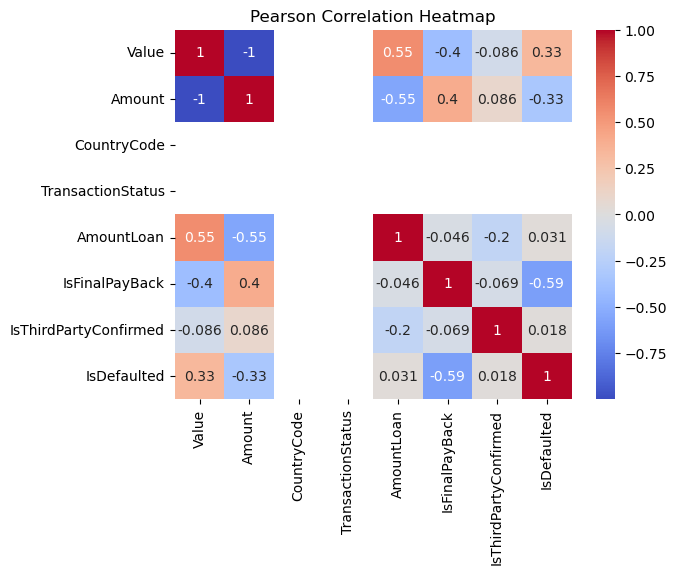

In [387]:
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm')
plt.title("Pearson Correlation Heatmap")
plt.show()